In [1]:
import ncar_jobqueue

In [2]:
cluster = ncar_jobqueue.NCARCluster(
#    cores=9,  # The number of cores you want
    memory='100GB',  # Amount of memory
#    processes=9,  # How many processes
    walltime='04:00:00',  # Amount of wall time
    project="ncgd0011",  #Project id
)

cluster.scale(32)


/glade/u/home/pmora/.conda/envs/etpac/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36902 instead
  warnings.warn(


In [3]:
%matplotlib inline
%load_ext autoreload
%load_ext watermark

from etpac import annotate_stats
import dask
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
#import pandas as pd
import xarray as xr
#import xgcm
import cartopy.crs as cr
from cartopy import feature as cf

mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.dpi"] = 180

xr.set_options(keep_attrs=True, display_style="html")

%watermark -iv

ncar_jobqueue: 2021.4.14
json         : 2.0.9
dask         : 2021.6.0
sys          : 3.9.4 | packaged by conda-forge | (default, May 10 2021, 22:13:33) 
[GCC 9.3.0]
xarray       : 0.18.2
pandas       : 1.4.4
numpy        : 1.20.3
matplotlib   : 3.5.3
distributed  : 2021.6.0
cartopy      : 0.19.0.post1



In [6]:
client = distributed.Client(cluster)
client

Client Scheduler: tcp://10.12.206.22:45679 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/pmora/proxy/36902/status,Cluster Workers: 32 Cores: 64 Memory: 800.00 GiB


In [7]:
files2 = '/glade/scratch/pmora/monthly_tauy.nc'

In [12]:
DS2 = xr.open_mfdataset(
    files2,
    compat="override",
    data_vars="minimal",
    coords="minimal",
    parallel=True,
    concat_dim="time",
    combine="nested",
)
#[["so", "thetao", "uo", "vo", "wo"]]

In [13]:
Ty= DS2["tauy"]
Ty

<xarray.DataArray 'tauy' (month: 12, yq: 340, xh: 460)>
dask.array<open_dataset-5c06e9392e36a59e2047250aab10c119tauy, shape=(12, 340, 460), dtype=float32, chunksize=(12, 340, 460), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 260.0 260.1 260.1 260.2 ... 282.8 282.9 282.9 283.0
  * yq       (yq) float64 0.0 0.05 0.1 0.15 0.2 ... 16.75 16.8 16.85 16.9 16.95
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:          Pa
    long_name:      Meridional surface stress ocean interactions with atmos a...
    cell_methods:   yq:point xh:mean time: point
    standard_name:  surface_downward_y_stress
    interp_method:  none

In [20]:
Tys = Ty.sel(xh=slice(273, 275), yq=slice(9.5, 11.5))  
Tys



<xarray.DataArray 'tauy' (month: 12, yq: 41, xh: 40)>
dask.array<getitem, shape=(12, 41, 40), dtype=float32, chunksize=(12, 41, 40), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 273.0 273.1 273.1 273.2 ... 274.8 274.9 274.9 275.0
  * yq       (yq) float64 9.5 9.55 9.6 9.65 9.7 ... 11.3 11.35 11.4 11.45 11.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:          Pa
    long_name:      Meridional surface stress ocean interactions with atmos a...
    cell_methods:   yq:point xh:mean time: point
    standard_name:  surface_downward_y_stress
    interp_method:  none

In [17]:
#dyCu_sm.plot.contour(lonq='lon',latq='lat',col_wrap=3)

In [18]:
#uEk_intp.plot.contourf(lonq='longitude',lath='latitude',col='month',col_wrap=3)

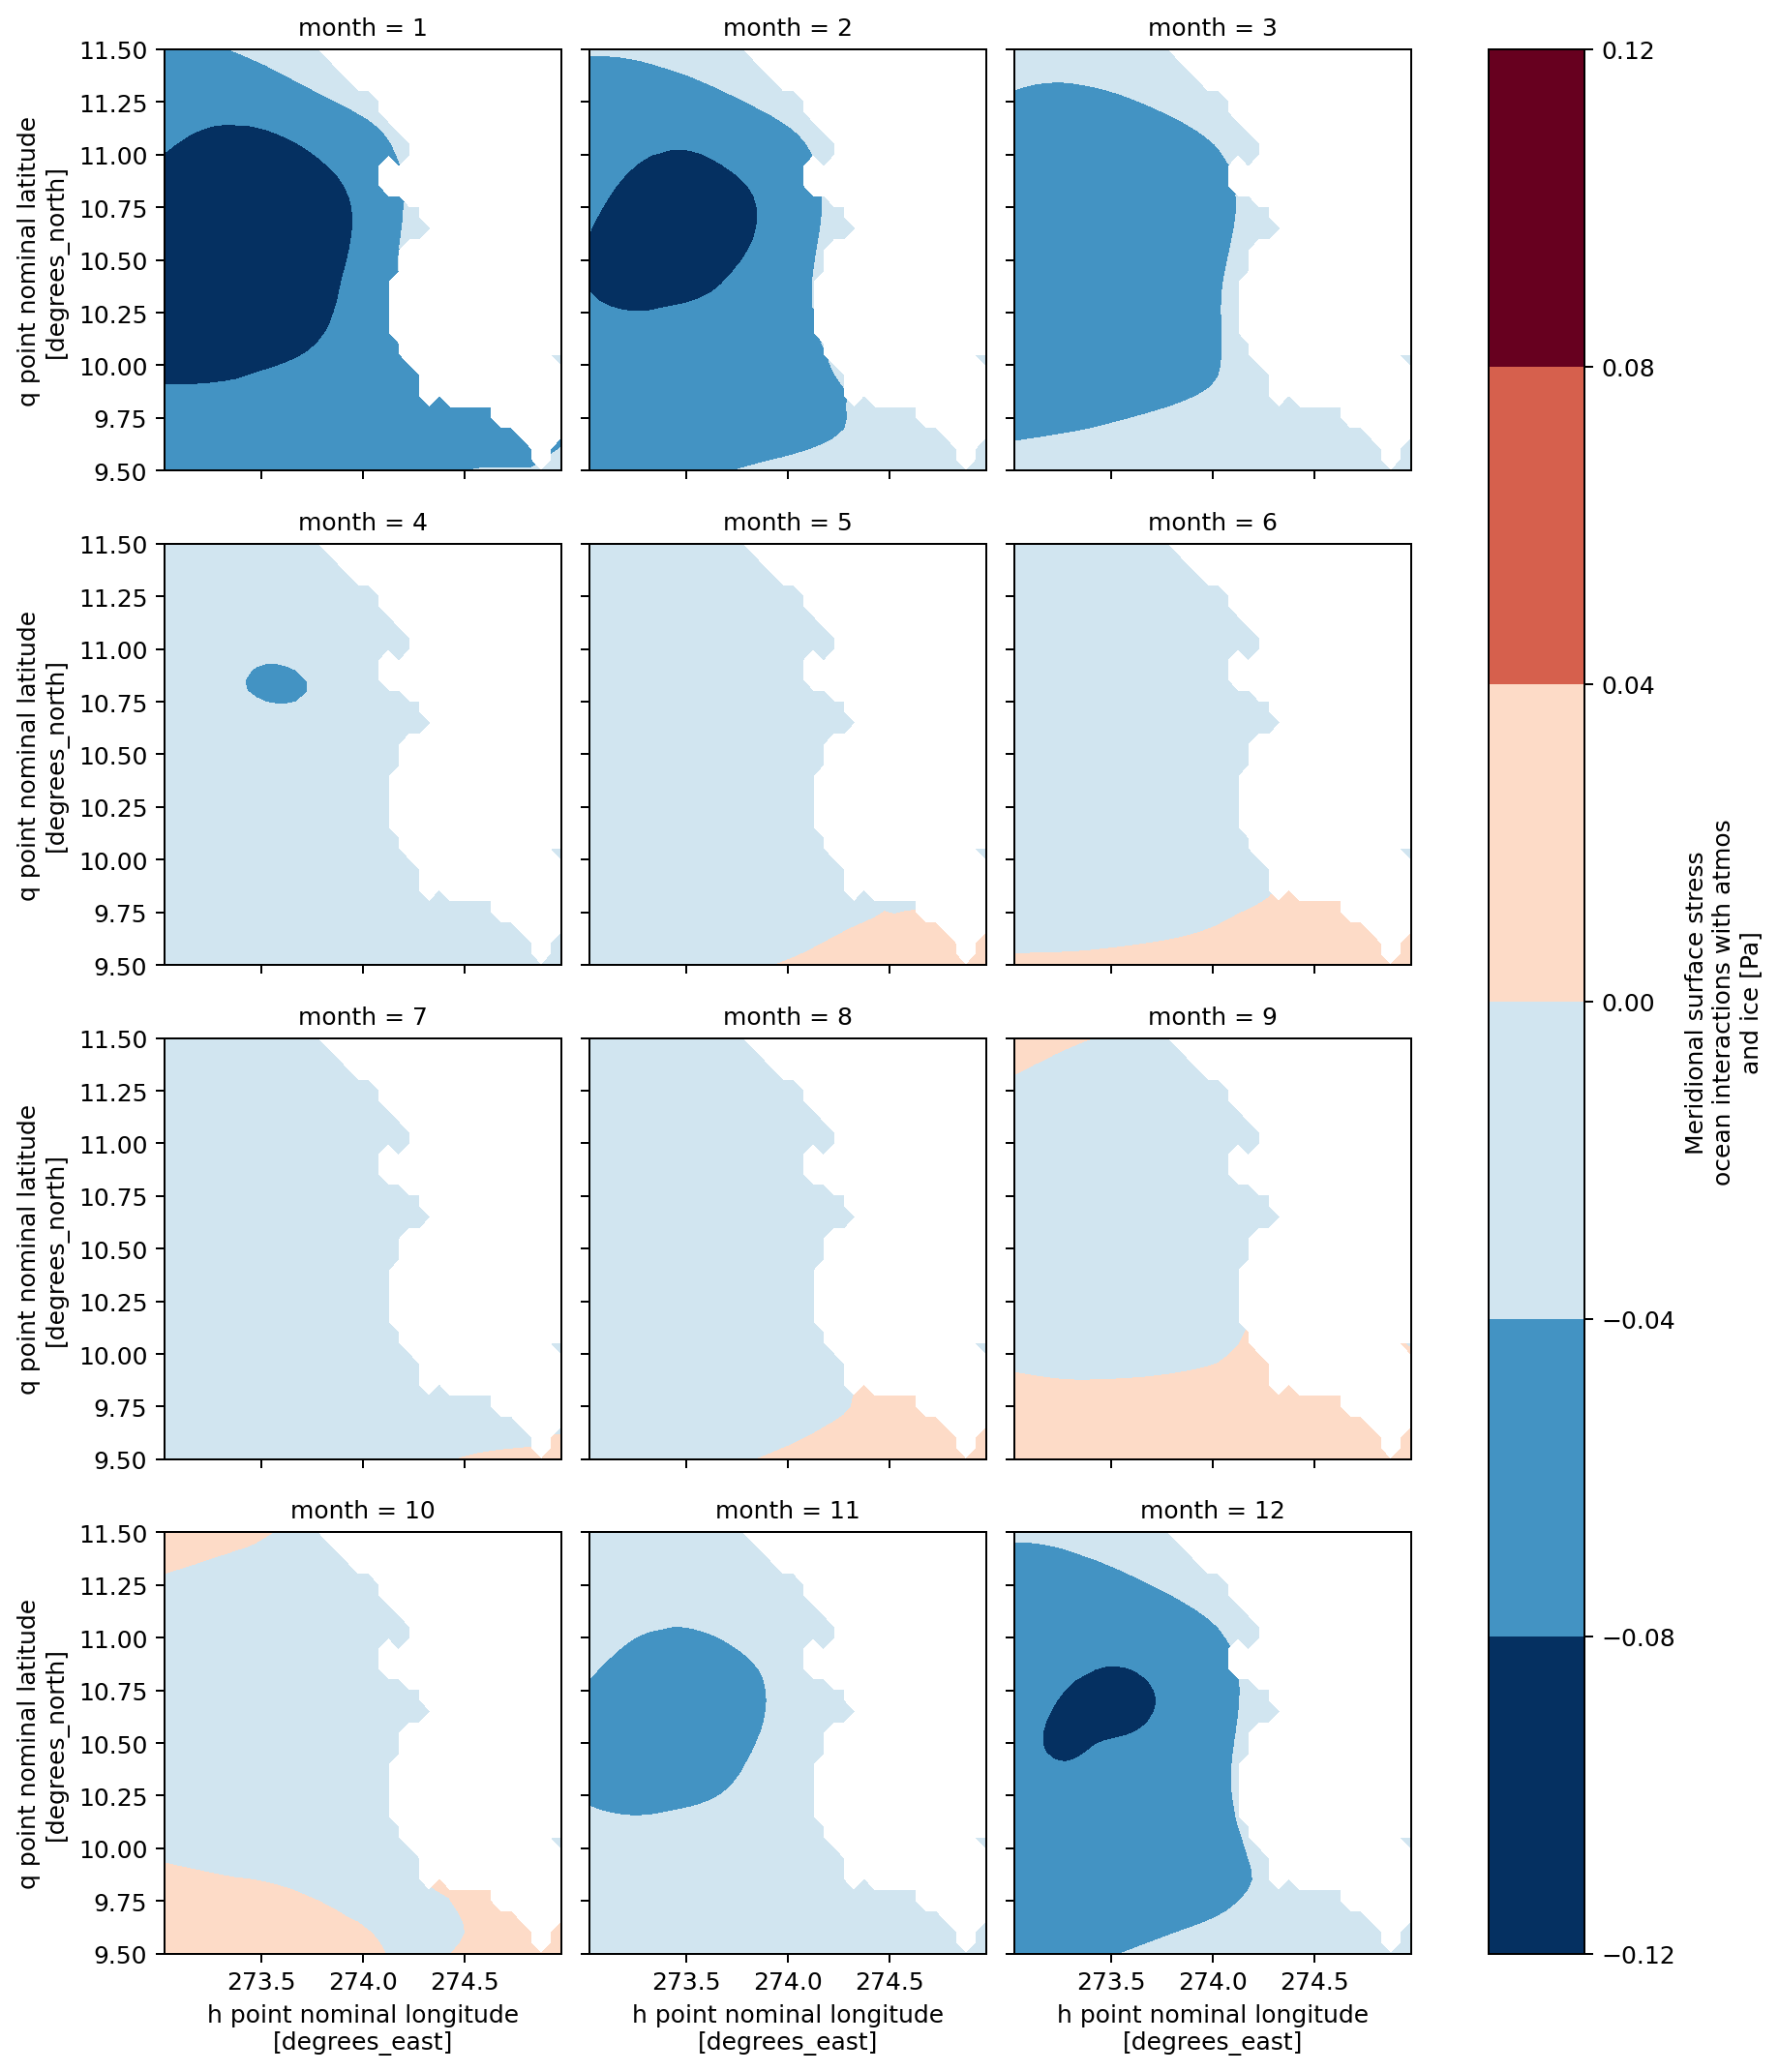

In [16]:
Tys.plot.contourf(lonq='longitude',lath='latitude',col='month',col_wrap=3)

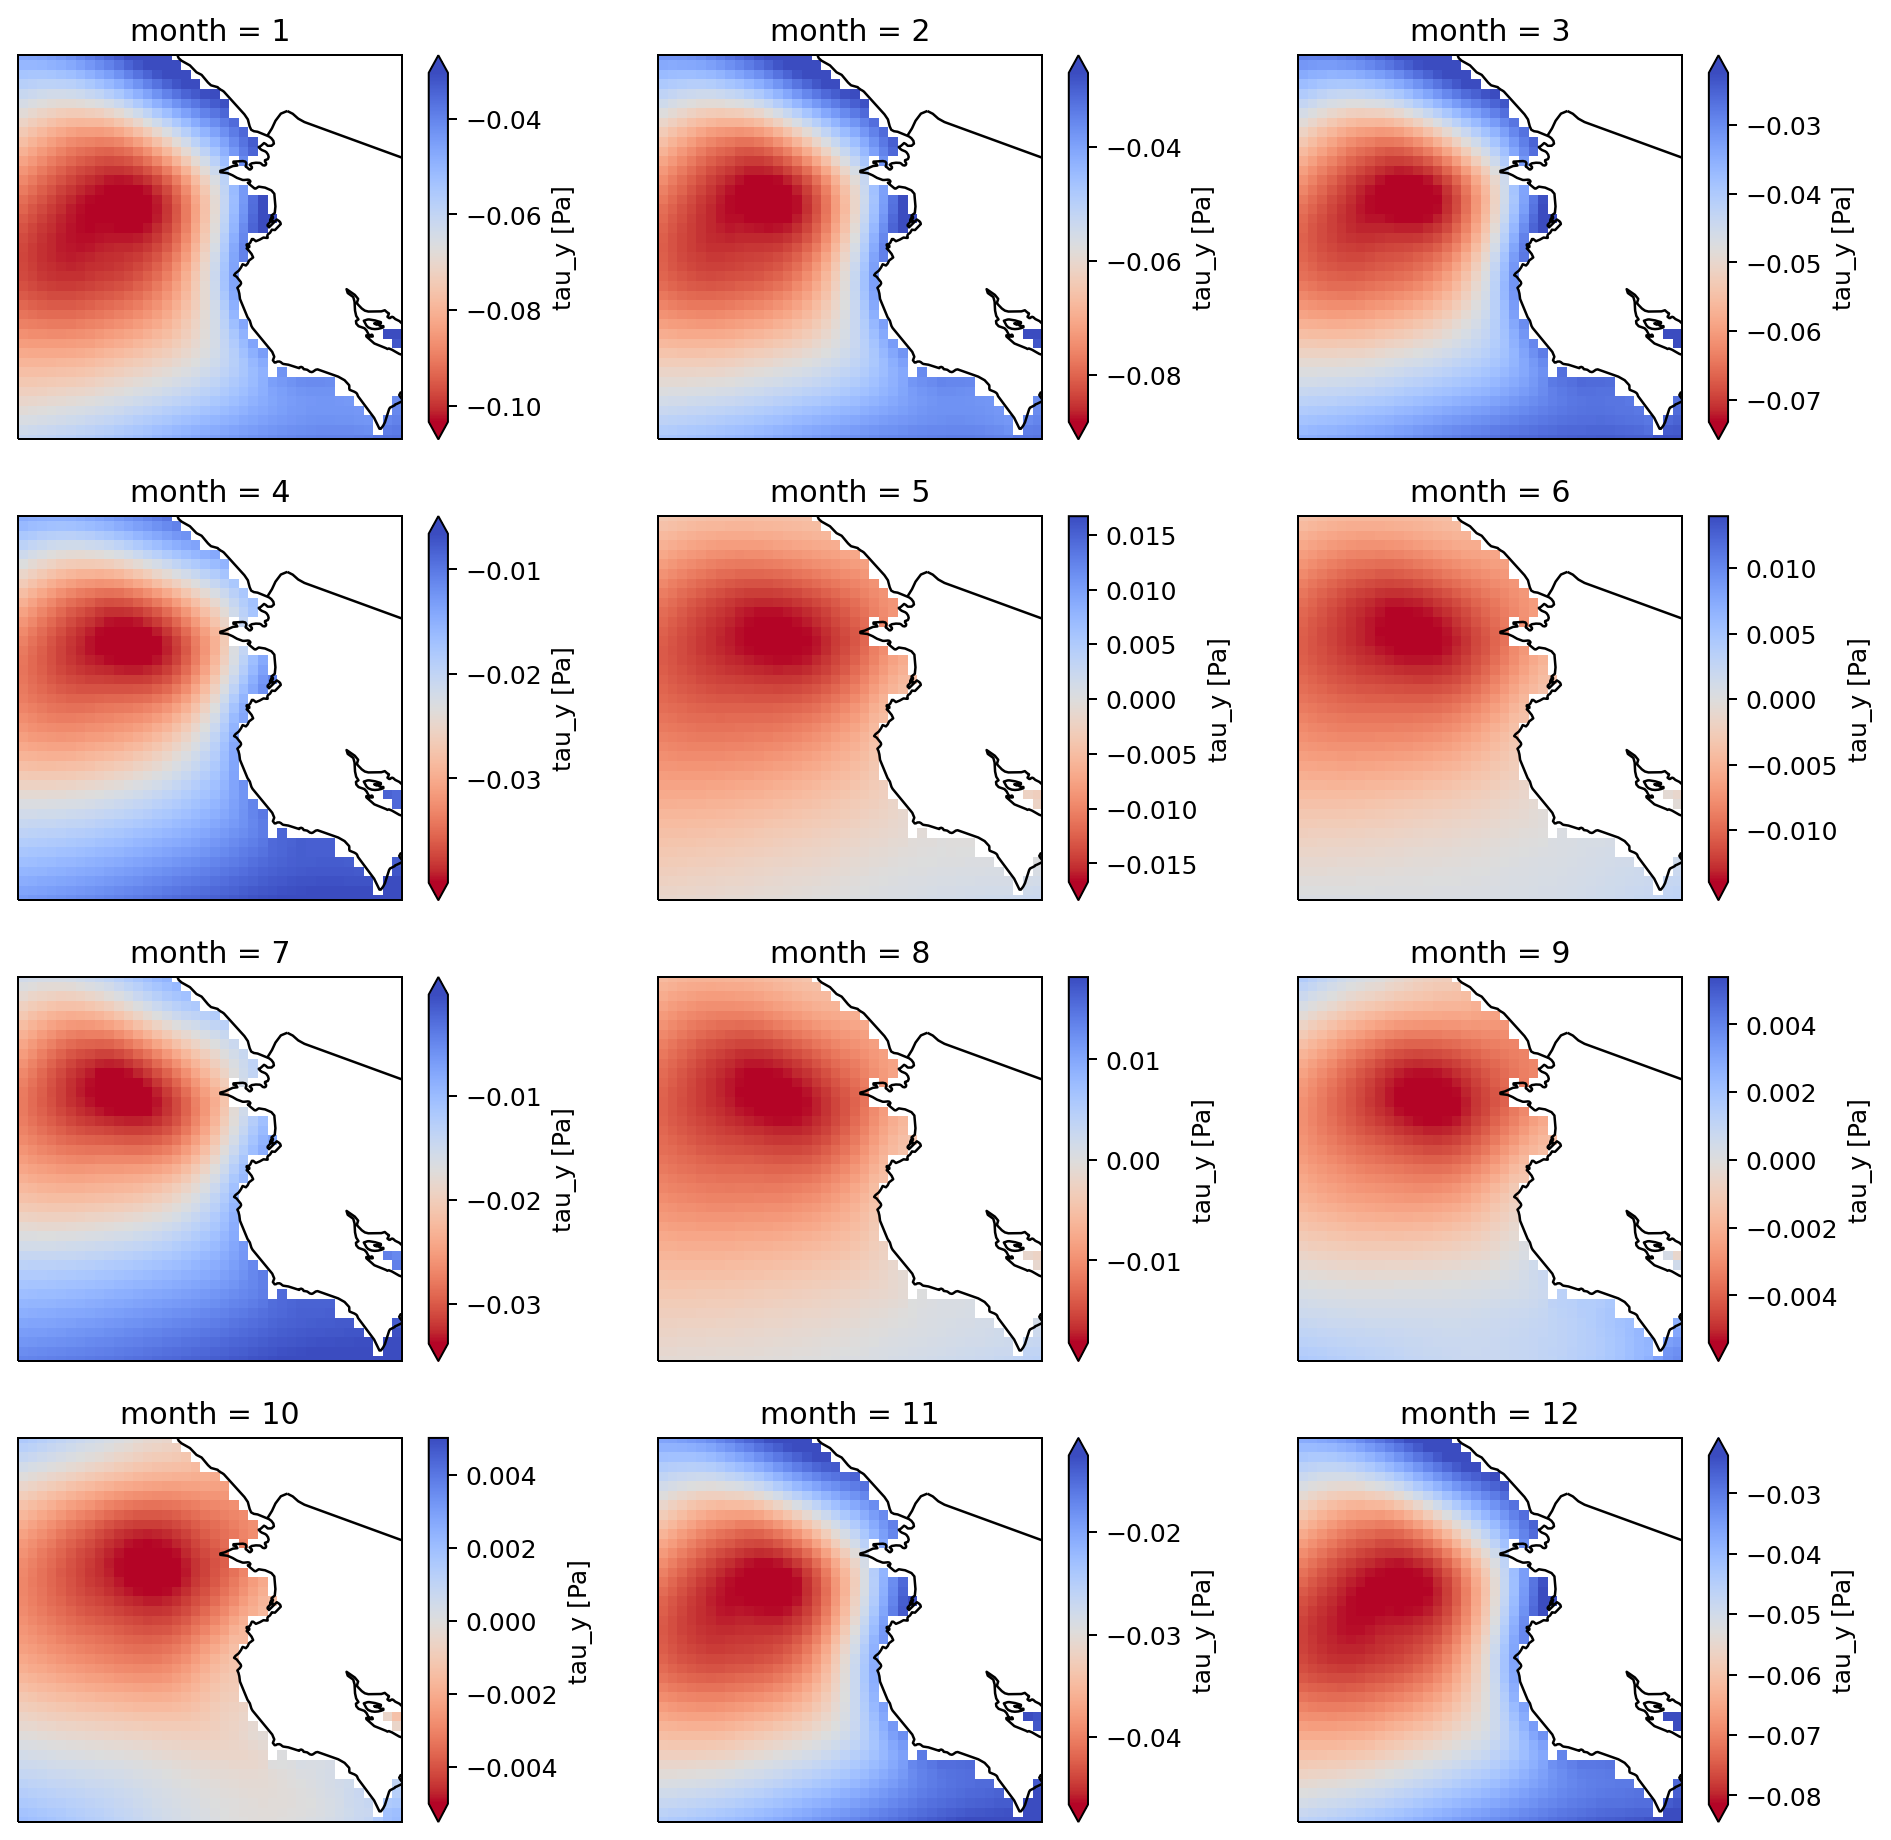

In [19]:
count = 0
fig=plt.figure(figsize=(13,13))
for mes in Tys.month:
             count+=1
             ax=fig.add_subplot(4,3,count,projection=cr.PlateCarree())
             Tys[Tys.month==mes].plot( cmap="coolwarm_r", cbar_kwargs={"label": "tau_y [Pa]"}, robust=True)
#             annotate_stats(plt.gca(), Ep2[Ep2.month==mes], x=0.3, y=0.4)
             ax.coastlines(resolution='10m')
             ax.add_feature(cf.BORDERS)
             ax.set_extent([-87, -85, 9.5,11.5])

In [ ]:
Ep2g = Ep2.interp(xq=Ep1["xh"])  #Esti sirvió, pero hay que quitarle la coordenada Xq
Ep2g

In [ ]:
Ep2g = Ep2g.drop_vars('xq') # Se le quita la coordenada xq

In [ ]:
#Ep2_g = Ep2_g.rename({'xq': 'xh'}) # change the name of the coordinate
#Ep2_g

In [ ]:
#del Ep2_g.attrs['interp_method']

In [ ]:
#En m/dia
Ep = Ep1 + Ep2g 
Ep

In [ ]:
#En cm/s
Epcm = Ep*0.00115741

In [ ]:
EP = Ep.to_netcdf('/glade/scratch/pmora/monthly_Ekman_pumping.nc')

In [ ]:
#Ep2 = Ep.sel(xh=np.arange(272,277,0.05), yh=np.arange(8,12,0.05), method="nearest")
Ep2 = Ep.sel(xh=slice(272, 277), yh=slice(8, 13))              
Ep2

In [ ]:
Ep2cm = Epcm.sel(xh=slice(272, 277), yh=slice(8, 13))              
Ep2cm

In [ ]:
Ep.plot.contourf(xh='lon',yh='lat',col='month',col_wrap=3)

In [ ]:
client.close()
cluster.close()